# Supplementary analyses: Meta-Analysis of Brain-to-Brain Synchrony Studies

In [ ]:
#### Import modules and set base variables

In [2]:
from os.path import join
from numpy import diag
from nilearn.image import load_img, index_img, resample_img, resample_to_img, math_img
from nilearn.masking import intersect_masks
from _scripts.help_fun import csv_to_nimare_ds, plot_gb
from _scripts.ma_fun import run_ale, run_loeo, exp_contributions, rel_abs_distributions

# directories 
wd = '/Users/leonlotter/MAsync/'
ALE_dir = join(wd, 'ALE')
CONN_dir = join(wd, 'CONN')
MACM_dir = join(CONN_dir, 'MACM')
RSFC_dir = join(CONN_dir, 'RSFC')
DECODE_dir = join(wd, 'DECODE')

# ALE settings
n_perm = 1000
v_thr = 0.001
n_core = -1

# Load brain-to-brain synchrony studies into a NIMARE database
db = csv_to_nimare_ds(join(wd, 'MAsync_ALE.xlsx'), 'publication', 'n', 'contrasts', 'space', 'x', 'y', 'z', sheet='Coordinates')
db_pp = csv_to_nimare_ds(join(wd, 'MAsync_ALE.xlsx'), 'publication', 'n', 'contrasts', 'space', 'x', 'y', 'z', sheet='Coordinates_pp')

Converting TAL coordinates from Silbert 2014 to MNI.
Converting TAL coordinates from Stephens 2010 to MNI.
Concatenating coordinates over multiple contrasts per study.
Imported data from 21 studies with 21 contrasts, XXX participants and 292 foci into NIMARE database
Converting TAL coordinates from Silbert 2014 to MNI.
Converting TAL coordinates from Stephens 2010 to MNI.
Converting TAL coordinates from Wang 2021 pp to MNI.
Concatenating coordinates over multiple contrasts per study.
Imported data from 22 studies with 22 contrasts, XXX participants and 313 foci into NIMARE database


## ALEs to assess potential counfounds

In [ ]:
## ONLY VOXEL-WISE BRAIN-TO-BRAIN SYNCHRONY

## ONLY "REAL" 

# Resting-state functional connectivity
We perform seed-based RSFC analyses on [HCP data](https://www.humanconnectome.org/study/hcp-young-adult/document/900-subjects-data-release) using the [CONN toolbox](https://doi.org/10.1089/brain.2012.0073) in MATLAB.  
**Sample**: N = 120 unrelated subjects evenly drawn from each age group and gender. N = 115 after exclusion of subjects exceding motion cut-offs.  
**Data**: S900 ICA-FIX denoised volumetric data; improved image reconstruction algorithm ("r277"); concatenated first two resting-state sessions (30 min); voxel-size 2x2x2 m^3.  
**Further processing**: Segmentation of structural volumes; Smoothing of functional volumes (6 mm FWHM); CompCor denoising; Linear detrending & bandpass filtering (0.01 - 0.08); Pearson correlations between averaged time series of rTPJ cluster and every voxel. The [batch script](../src/HCP_batch.m) is based on the HCP script provided with the CONN toolbox.   
**Statistics**: Two-sided one-sample t-test on the standardized voxel values; voxel threshold p < 0.001; cluster threshold p < 0.05, FWE-corrected based on the non-parametric Monte-carlo simulation procedure implemented in CONN (1000 iterations). We then only look at positive connectivity between the ALE cluster and the whole brain within a grey matter mask.

The resulting resting-state network is widely distributed across the brain, broadly covering the MACM clusters but extending also to superior frontal gyrus, precuneus as well as subcortical and cerebellar regions.

In [ ]:
# load thresholded and masked SPM RSFC volume from CONN 
rsfc = load_img(join(wd, 'rsfc', 'rsfc_rTPJ_CONN.nii'))
# binarize and save volume
rsfc_bin = math_img('img > 0', img=rsfc)
rsfc_bin.to_filename(join(wd, 'conn_rsfc_rTPJ.nii.gz'))
# plot
plot_gb(rsfc, title='Positive RSFC, seed = rTPJ cluster', col='cold_hot')

### Conjunction of MACM & RSFC
The consensus network of regions functionally connected to the rTPJ cluster via conjunction of MACM and RSFC results.

Due to the broadly distributed RSFC clusters, the conjunction network seems largely driven by MACM results. We find large clusters on bilateral TPJ and right inferior/ medial frontal gyrus/ insula.

In [ ]:
NW_conj = intersect_masks([macm_res_bin, rsfc_bin], 1, connected=False)
NW_conj.to_filename(join(wd, 'conn_conj_rTPJ.nii.gz'))
# plot result
plot_gb(NW_conj, title='Conjunction of MACM & RSFC, seed = rTPJ cluster')

## Connectivity analyses on right frontal cluster

The Python package you are importing, AtlasReader, is licensed under the
BSD-3 license; however, the atlases it uses are separately licensed under more
restrictive frameworks.
By using AtlasReader, you agree to abide by the license terms of the
individual atlases. Information on these terms can be found online at:
https://github.com/miykael/atlasreader/tree/master/atlasreader/data

Calculating ALE on 280 experiments with 286 contrasts, XXX participants and 5629 foci.
Thresholding: voxel-level p < 0.001, cluster-level p < 0.05, significance determined by random relocation of foci with 1000 iterations.


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


ALE completed, results saved to:
 /Users/leonlotter/MAsync/CONN/MACM/res_supp


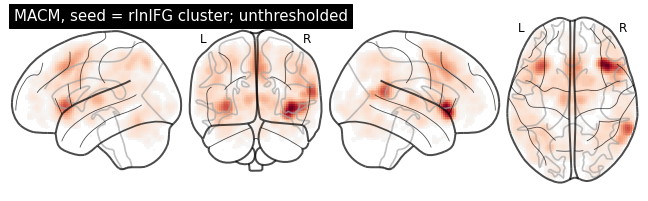

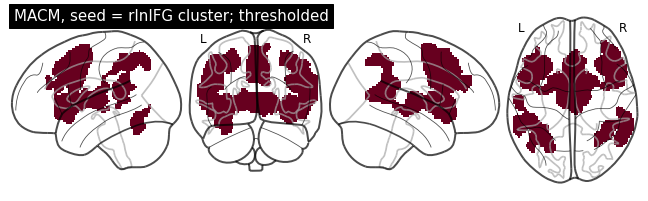

In [3]:
## MACM ----------------------------------------------------------
MACM_sleuth_file = join(MACM_dir, 'MAsync_ALEpp_rInIFG.txt') 
# perform MACM ALE
MACM_res, MACM_res_z, MACM_res_mask = run_ale(data=MACM_sleuth_file, work_dir=join(MACM_dir, 'res_supp'), pref='MAsync_MACM_rInIFG_', 
            vox_thr=v_thr, n_perm=n_perm, n_core=n_core, glassbrain_title='MACM, seed = rInIFG cluster')

## RSFC ----------------------------------------------------------

plot_gb(join(RSFC_dir, ), title='Positive RSFC, seed = rInIFG cluster')

## CONJ ----------------------------------------------------------
NW_conj = intersect_masks([MACM_res_mask, load_img(join(RSFC_dir, ))], 1, connected=False)
NW_conj.to_filename(join(CONN_dir, 'MAsync_CONN_conjunction.nii.gz'))
plot_gb(NW_conj, title='Conjunction of MACM & RSFC')